#### When embeddings fails to retrieve (good results)
--------------------------

| **Reason**               | **Description**                                                                                          | **Solution**                                                                                      | **Example**                                                                                                                |
|--------------------------|----------------------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------|----------------------------------------------------------------------------------------------------------------------------|
| **Embedding Model Mismatch** | The embedding model is not aligned with the specific domain or task.                                  | Use a domain-specific model (e.g., `BioBERT` for medical data).                                   | Load a specialized model: `SentenceTransformer('biobert-base-cased-v1')`.                                                 |
| **Insufficient or Noisy Data** | Sparse or noisy input data prevents meaningful embeddings.                                           | Clean and preprocess the data to remove noise or enhance context.                                | Remove stopwords, apply stemming/lemmatization, and normalize case.                                                       |
| **Domain Shift**          | The model was pre-trained on data different from the target domain.                                     | Fine-tune the embedding model with task-specific datasets.                                       | Use datasets like SNLI or STS for fine-tuning.                                                                            |
| **Low Granularity**       | Sentence/document-level embeddings miss token-level nuances.                                            | Combine hierarchical embeddings for multi-level granularity.                                     | Merge sentence-level (`SBERT`) with token-level (`BERT`) embeddings.                                                      |
| **Improper Vector Similarity** | Incorrect similarity metric leads to inaccurate comparisons.                                         | Use cosine similarity for dense embeddings unless otherwise specified.                           | Use `util.pytorch_cos_sim()` in the SentenceTransformers library.                                                         |
| **Outdated Embedding Models** | Older models may lack features or optimizations present in newer models.                             | Test newer models or architectures (e.g., OpenAI embeddings, SBERT).                             | Replace legacy models like `bert-base-uncased` with `all-MiniLM-L6-v2`.                                                   |
| **Unoptimized Indexing**  | Poorly tuned vector search indices reduce retrieval quality.                                            | Use optimized libraries like FAISS with parameter tuning for better indexing and retrieval.      | Configure FAISS with the correct number of neighbors and clustering parameters.                                            |


In [5]:
from helper_utils import load_chroma, word_wrap

In [2]:
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction

In [3]:
embedding_function = SentenceTransformerEmbeddingFunction()

In [4]:
%%time
chroma_collection = load_chroma(filename          = r'./data/microsoft_annual_report_2022.pdf', 
                                collection_name   = 'microsoft_annual_report_2022', 
                                embedding_function= embedding_function)
chroma_collection.count()

CPU times: total: 32.7 s
Wall time: 40.4 s


349

#### Visualize the embedding space

In [6]:
#pip install umap

In [7]:
#pip install umap-learn

In [9]:
import umap.umap_ as umap  # Correct import
import numpy as np
from tqdm import tqdm

In [10]:
embeddings = chroma_collection.get(include=['embeddings'])['embeddings']

In [11]:
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)

D:\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [12]:
def project_embeddings(embeddings, umap_transform):
    
    umap_embeddings = np.empty((len(embeddings),2))
    
    for i, embedding in enumerate(tqdm(embeddings)): 
        umap_embeddings[i] = umap_transform.transform([embedding])
        
    return umap_embeddings   

In [13]:
%%time
# this takes a long time on CPUs
# try Colab
projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

100%|████████████████████████████████████████████████████████████████████████████████| 349/349 [00:04<00:00, 78.28it/s]

CPU times: total: 1.91 s
Wall time: 4.49 s


In [14]:
import pickle

In [15]:
# Assuming 'projected_dataset_embeddings' is the transformed dataset
with open('projected_embeddings.pkl', 'wb') as f:
    pickle.dump(projected_dataset_embeddings, f)

In [16]:
with open('projected_embeddings.pkl', 'rb') as f:
    projected_dataset_embeddings = pickle.load(f)

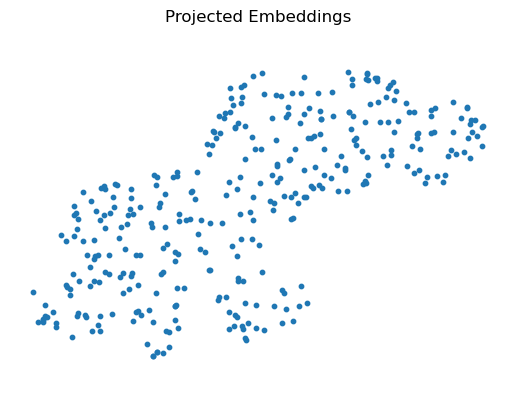

In [17]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10)
plt.gca().set_aspect('equal', 'datalim')
plt.title('Projected Embeddings')
plt.axis('off');

**Exercise** - use settings in UMAP which allows you to hover over dots and show Doc ID
- get nearby doc IDs (5 or 10 of the neighbors) and compare if they are similar docs

**Exercise** - try PCA or t-SNE or SVD (get similar plots and compare)

#### Relevancy and Distraction

In [18]:
query = "What is the total revenue?"

results = chroma_collection.query(query_texts = query, 
                                  n_results   = 5, 
                                  include     = ['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

for document in results['documents'][0]:
    print(word_wrap(document))
    print('')

74 note 13 — unearned revenue unearned revenue by segment was as
follows : ( in millions ) june 30, 2022 2021 productivity and business
processes $ 24, 558 $ 22, 120 intelligent cloud 19, 371 17, 710 more
personal computing 4, 479 4, 311 total $ 48, 408 $ 44, 141 changes in
unearned revenue were as follows : ( in millions ) year ended june 30,
2022 balance, beginning of period $ 44, 141 deferral of revenue 110,
455 recognition of unearned revenue ( 106, 188 ) balance, end of period
$ 48, 408 revenue allocated to remaining performance obligations, which
includes unearned revenue and amounts that will be invoiced and
recognized as revenue in future periods, was $ 193 billion as of june
30, 2022, of which $ 189 billion is related to the commercial portion
of revenue. we expect to recognize approximately 45 % of this revenue
over the next 12 months and the remainder thereafter. note 14 — leases

software assurance ( “ sa ” ) and cloud services. unearned revenue is
generally invoiced annual

In [19]:
query_embedding = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 134.63it/s]


(-3.985500180721283, 7.024163329601288, 5.957234501838684, 12.879533171653748)

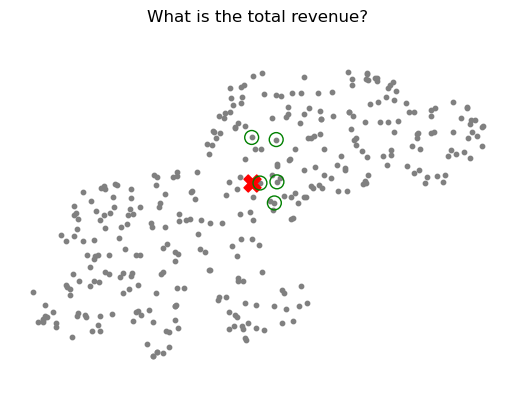

In [20]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0],   projected_dataset_embeddings[:, 1],   s=10,                     color='gray')
plt.scatter(projected_query_embedding[:, 0],      projected_query_embedding[:, 1],      s=150, marker='X',        color='r')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{query}')
plt.axis('off')

**Observation**
- some documents are related to revenue
- some are related to words like "research and development"
- some are related to costs but not revenuw

In [21]:
query   = "What is the strategy around artificial intelligence (AI) ?"
results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

for document in results['documents'][0]:
    print(word_wrap(document))
    print('')

culture of trust can help navigate the challenges the world faces
today. organizations of all sizes have digitized business - critical
functions, redefining what they can expect from their business
applications. customers are looking to unlock value while simplifying
security and management. from infrastructure and data, to business
applications and collaboration, we provide unique, differentiated value
to customers. we are building a distributed computing fabric – across
cloud and the edge – to help every organization build, run, and manage
mission - critical workloads anywhere. in the next phase of innovation,
artificial intelligence ( “ ai ” ) capabilities are rapidly advancing,
fueled by data and knowledge of the world. we are enabling metaverse
experiences at all layers of our stack, so customers can more
effectively model, automate, simulate, and predict changes within their
industrial

every organization turn its data into predictive and analytical power.
with our new microsoft 

In [22]:
query_embedding      = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding      = project_embeddings([query_embedding],    umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 174.76it/s]


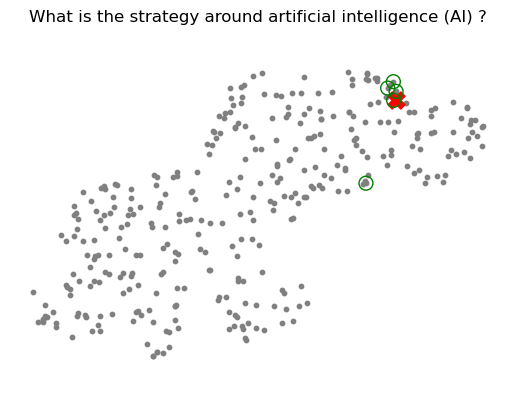

In [23]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{query}')
plt.axis('off');

**Observation**

- the retrived documents seem to be from a similar pool of documents
- but some of the retrieved documents do not seem related

In [24]:
query   = "What has been the investment in research and development?"
results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

for document in results['documents'][0]:
    print(word_wrap(document))
    print('')

• operating expenses increased $ 1. 5 billion or 14 % driven by
investments in gaming, search and news advertising, and windows
marketing. operating expenses research and development ( in millions,
except percentages ) 2022 2021 percentage change research and
development $ 24, 512 $ 20, 716 18 % as a percent of revenue 12 % 12 %
0ppt research and development expenses include payroll, employee
benefits, stock - based compensation expense, and other headcount -
related expenses associated with product development. research and
development expenses also include third - party development and
programming costs, localization costs incurred to translate software
for international markets, and the amortization of purchased software
code and services content. research and development expenses increased
$ 3. 8 billion or 18 % driven by investments in cloud engineering,
gaming, and linkedin. sales and marketing ( in millions, except
percentages ) 2022 2021

competitive in local markets and enable

In [25]:
query_embedding      = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding      = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 174.82it/s]


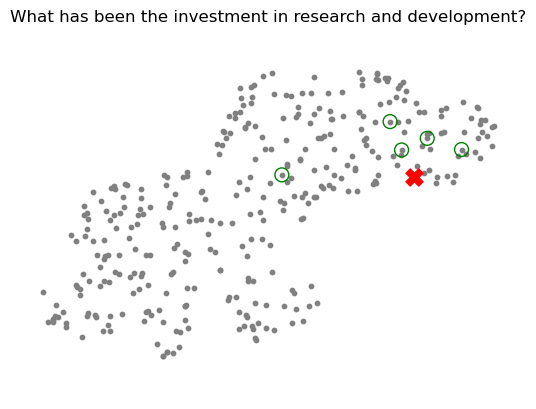

In [26]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{query}')
plt.axis('off');

**Observation**
- there are distractors in the results
- results are quite spread out

In [27]:
query   = "What has Michael Jordan done for us lately?"
results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

for document in results['documents'][0]:
    print(word_wrap(document))
    print('')

18 total rewards we develop dynamic, sustainable, market - driven, and
strategic programs with the goal of providing a highly differentiated
portfolio to attract, reward, and retain top talent and enable our
employees to thrive. these programs reinforce our culture and values
such as collaboration and growth mindset. managers evaluate and
recommend rewards based on, for example, how well we leverage the work
of others and contribute to the success of our colleagues. we monitor
pay equity and career progress across multiple dimensions. as part of
our effort to promote a one microsoft and inclusive culture, in fiscal
year 2021 we expanded stock eligibility to all microsoft employees as
part of our annual rewards process. this includes all non - exempt and
exempt employees and equivalents across the globe including business
support professionals and datacenter and retail employees. in response

19 • in - the - classroom learning, learning cohorts, our early - in -
career aspire program, a

In [28]:
query_embedding      = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 170.74it/s]


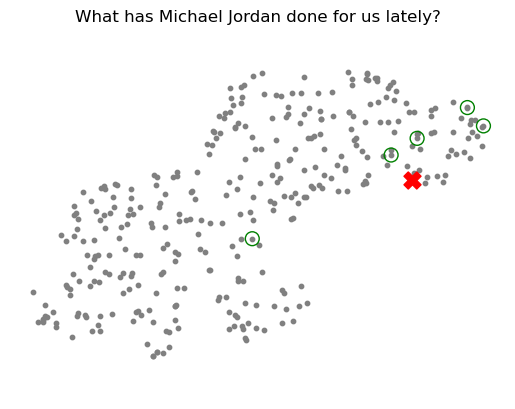

In [29]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{query}')
plt.axis('off');

------------------------------
#### How does UMAP work
----------------------

- **UMAP (Uniform Manifold Approximation and Projection)** is a dimensionality reduction technique that excels at preserving both local and global structure of high-dimensional data.

- **Goal**: Reduces high-dimensional data into lower dimensions (usually 2 or 3), preserving relationships between data points.


**Local Structure**
- `Local structure` refers to the relationships between nearby points in high-dimensional space. The goal is to keep close points in the original high-dimensional space close to each other in the low-dimensional embedding as well.
- Example of Local Structure:
    - Imagine a dataset of handwritten digits (like MNIST), where each digit image is represented by 784 dimensions (28x28 pixels).
    - Two images of the digit "1" may be very similar, differing only by small variations in handwriting.
    - These two images are locally related because they represent the same digit and should be close in high-dimensional space.
    - When using a dimensionality reduction technique like UMAP, the algorithm should keep these similar images near each other in the 2D or 3D projection.

**Global Structure**
- `Global structure` refers to the broader, overarching relationships between clusters or groups of points in the dataset. It focuses on ensuring that the overall layout of points in the low-dimensional space reflects the true structure of the dataset.
- Example of Global Structure:
    - In the same MNIST dataset, images of different digits (e.g., "1" and "7") might form distinct clusters.
    - These clusters are globally related. While individual images of "1" and "7" might be close to each other in some cases, at the global scale, images of "1" should generally form a separate cluster from images of "7."
    - Preserving global structure means that UMAP should keep these clusters of different digits separated in the 2D or 3D embedding.

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

In [31]:
# Load the MNIST dataset
mnist = fetch_openml('mnist_784', version=1)
X = mnist.data
y = mnist.target.astype(int)

D:\anaconda3\Lib\site-packages\sklearn\datasets\_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [32]:
# Initialize UMAP
umap_model = umap.UMAP(n_neighbors=15, n_components=2, random_state=42)

In [33]:
# takes some time ... 3 - 5 mins
# Fit and transform the data
X_umap = umap_model.fit_transform(X)

D:\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [ ]:
# Plot the UMAP results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y, cmap='Spectral', s=1, alpha=0.5)
plt.colorbar(scatter, ticks=range(10), label='Digit Label')
plt.title('UMAP Projection of the MNIST Dataset')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.show()